In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder

# 可視化ツールのimport
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))
#色コード
class CLR:
    map_1 = 'GnBu'
    blue_thin = '#88CAC9'
    blue_dark = '#38A6A5'
    pink_thin = '#eb8792'
    pink_dark = '#ec616e'
    orange = '#f8b287'
    orange_dark = '#ee572a'

ModuleNotFoundError: No module named 'pandas'

In [3]:
df_train = pd.read_csv('./kaggle/input/titanic/train.csv')
df_test = pd.read_csv('./kaggle/input/titanic/test.csv')
df_example = pd.read_csv('./kaggle/input/titanic/gender_submission.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def preprocess(df:pd.core.frame.DataFrame, istrain:bool) -> pd.core.frame.DataFrame:
    droped_columns = ['PassengerId','Name','Ticket',"Cabin"]
    df = df.drop(columns=droped_columns)
    df = df.fillna(df.mode().iloc[0])
    df = pd.get_dummies(df)
    if istrain == True:
        target_column = df['Survived']
        df.drop(columns='Survived', inplace=True)

    scaler=StandardScaler()
    df_scaled =pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
    # Survived列を元のDataFrameに結合
    if istrain == True:
        df_scaled['Survived'] = target_column
    return df

df_preprocessed = preprocess(df_train, True)
df_preprocessed_test = preprocess(df_test, False)
df_preprocessed.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,38.0,1,0,71.2833,True,False,True,False,False
2,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,35.0,1,0,53.1000,True,False,False,False,True
4,3,35.0,0,0,8.0500,False,True,False,False,True


In [6]:
# 欠損値がないか確認
df_preprocessed.isnull().sum(axis=0)#データの欠測値を一覧表示

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
df_train_x = df_preprocessed
df_train_y = df_train['Survived']
x_train, x_val, y_train, y_val = train_test_split(df_train_x, df_train_y, test_size=0.15, random_state=42)

X_test = df_preprocessed_test

In [8]:
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))
    
    return xgb_pred_y, model_xgb

In [10]:
X_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,False,True,False,True,False
1,3,47.0,1,0,7.0000,True,False,False,False,True
2,2,62.0,0,0,9.6875,False,True,False,True,False
3,3,27.0,0,0,8.6625,False,True,False,False,True
4,3,22.0,1,1,12.2875,True,False,False,False,True


In [18]:
# Training LGB
y_pred_xgb, model_xgb = run_xgb(x_train, y_train, x_val, y_val, X_test)
print("XGB Training Completed...")

[13:26:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:0.49972	valid-rmse:0.49978


c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use i

[100]	train-rmse:0.47463	valid-rmse:0.47909
[200]	train-rmse:0.45143	valid-rmse:0.46080
[300]	train-rmse:0.42988	valid-rmse:0.44463
[400]	train-rmse:0.41027	valid-rmse:0.43038
[500]	train-rmse:0.39242	valid-rmse:0.41780
[600]	train-rmse:0.37640	valid-rmse:0.40702
[700]	train-rmse:0.36164	valid-rmse:0.39742
[800]	train-rmse:0.34823	valid-rmse:0.38923
[900]	train-rmse:0.33599	valid-rmse:0.38199
[1000]	train-rmse:0.32520	valid-rmse:0.37598
[1100]	train-rmse:0.31553	valid-rmse:0.37111
[1200]	train-rmse:0.30627	valid-rmse:0.36681
[1300]	train-rmse:0.29786	valid-rmse:0.36305
[1400]	train-rmse:0.29000	valid-rmse:0.35990
[1500]	train-rmse:0.28322	valid-rmse:0.35720
[1600]	train-rmse:0.27696	valid-rmse:0.35511
[1700]	train-rmse:0.27134	valid-rmse:0.35342
[1800]	train-rmse:0.26566	valid-rmse:0.35185
[1900]	train-rmse:0.26098	valid-rmse:0.35046
[1999]	train-rmse:0.25615	valid-rmse:0.34923
XGB Training Completed...


c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\Intern\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use i

In [19]:
df_answer = pd.read_csv('./kaggle/input/titanic/answer.csv')
Y_test = df_answer['Survived']

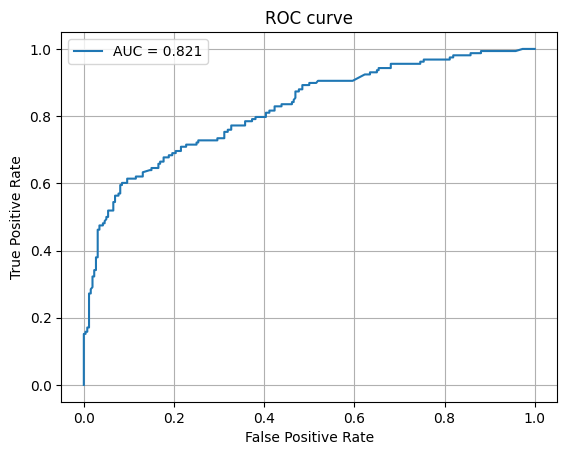

In [20]:

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_xgb)
auc_score = roc_auc_score(Y_test, y_pred_xgb)
plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)


# accuracy: 0.8208955223880597
# f1_score: 0.7446808510638298
